Fron the book: Hands_On_Machine_Learning_with_Scikit_Learn_and_TensorFlow

In [ ]:
import tensorflow as tf

TensorFlow is a powerful open source software library for numerical computation,
particularly well suited and fine-tuned for large-scale Machine Learning. Its basic
principle is simple: you first define in Python a graph of computations to perform
(for example, the one in Figure 9-1), and then TensorFlow takes that graph and runs
it efficiently using optimized C++ code.

It provides a very simple Python API called TF.Learn2 (tensorflow.con
trib.learn), compatible with Scikit-Learn. As you will see, you can use it to
train various types of neural networks in just a few lines of code. It was previously
an independent project called Scikit Flow (or skflow).

It also provides another simple API called TF-slim (tensorflow.contrib.slim)
to simplify building, training, and evaluating neural networks.

Several other high-level APIs have been built independently on top of Tensor‐
Flow, such as Keras or Pretty Tensor.

Its main Python API offers much more flexibility (at the cost of higher complexity)
to create all sorts of computations, including any neural network architecture
you can think of.

It includes highly efficient C++ implementations of many ML operations, particularly
those needed to build neural networks. There is also a C++ API to define
your own high-performance operations.

It provides several advanced optimization nodes to search for the parameters that
minimize a cost function. These are very easy to use since TensorFlow automatically
takes care of computing the gradients of the functions you define. This is
called automatic differentiating (or autodiff).


It also comes with a great visualization tool called TensorBoard that allows you to
browse through the computation graph, view learning curves, and more.

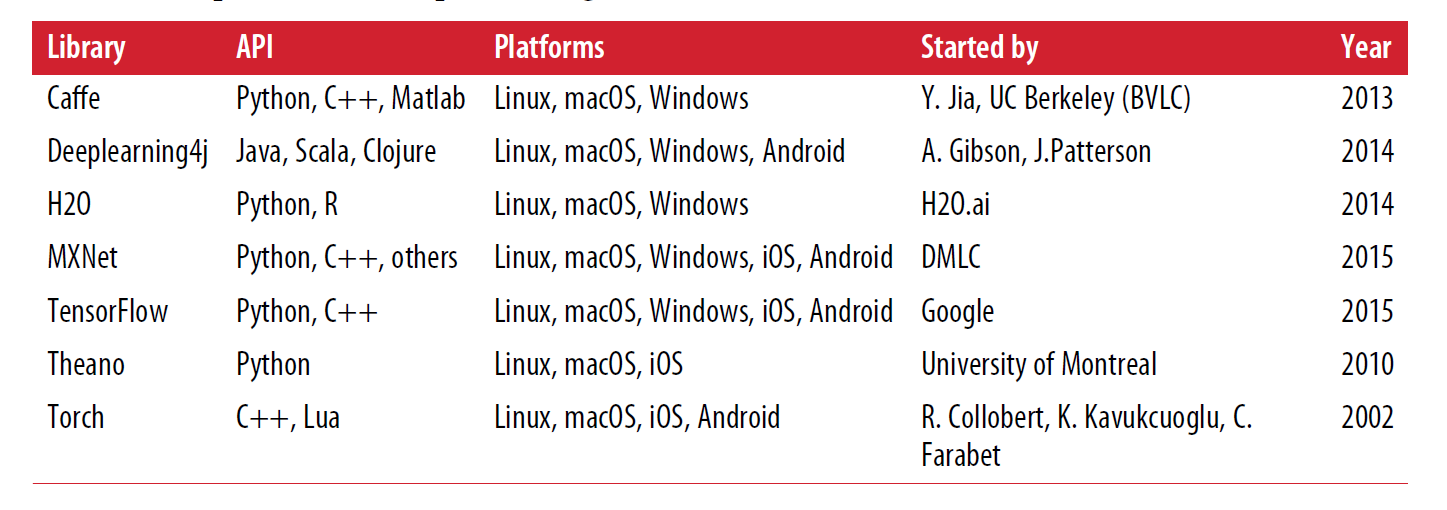

First graph:

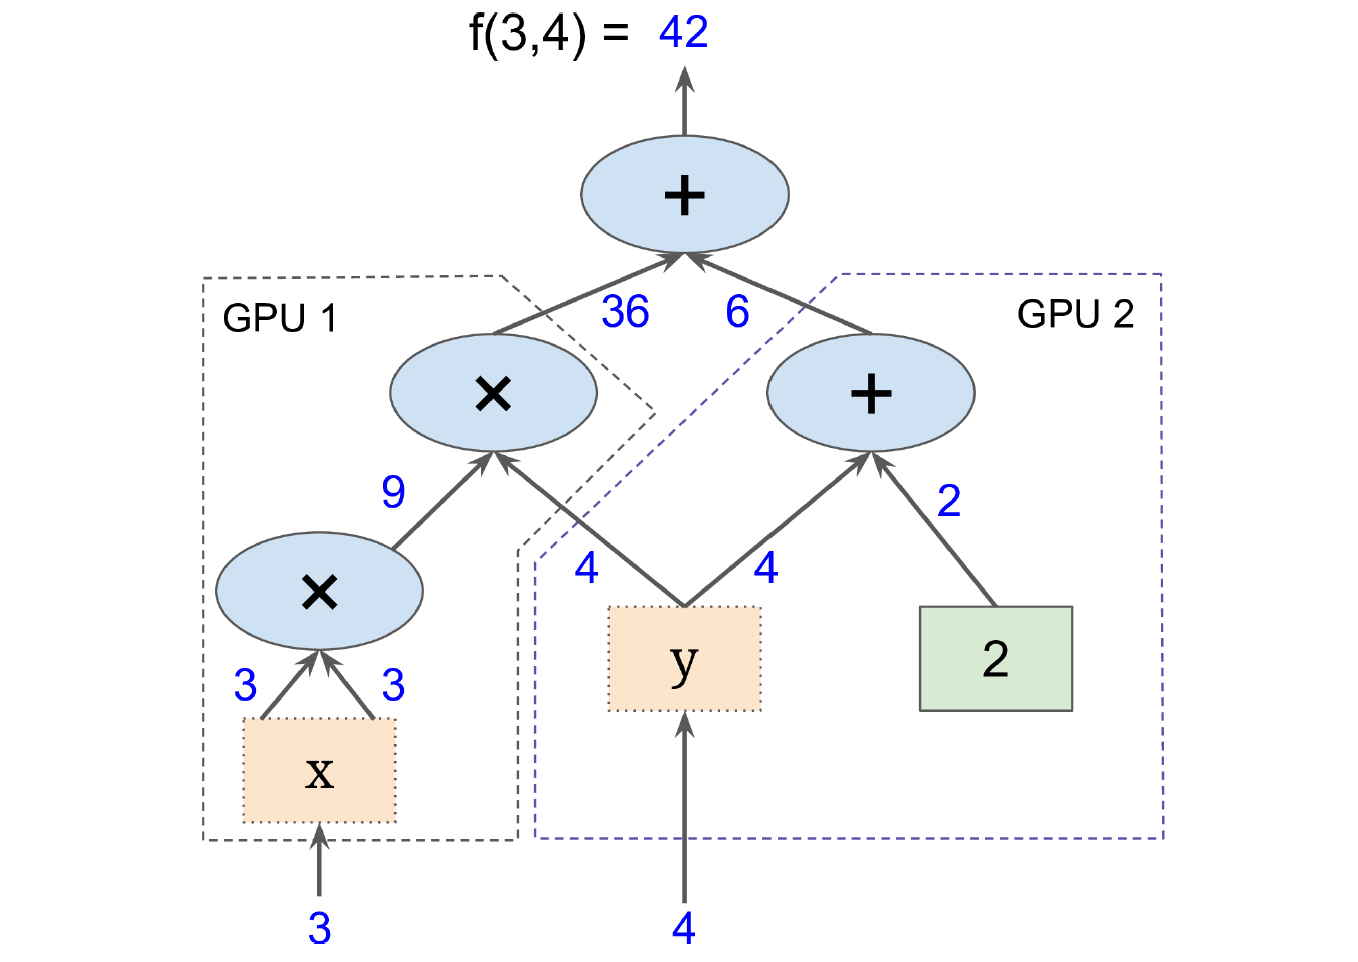

In [3]:
# define var
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

In [5]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()
    
print(result)

42


Inside the with block, the session is set as the default session. Calling x.initial
izer.run() is equivalent to calling tf.get_default_session().run(x.initial
izer), and similarly f.eval() is equivalent to calling
tf.get_default_session().run(f). This makes the code easier to read. Moreover,
the session is automatically closed at the end of the block.

Instead of manually running the initializer for every single variable, you can use the
global_variables_initializer() function. Note that it does not actually perform
the initialization immediately, but rather creates a node in the graph that will initialize
all variables when it is run:

In [7]:
init = tf.global_variables_initializer() # prepare an init node
with tf.Session() as sess:
    init.run() # actually initialize all the variables
    result = f.eval()

print(result)

42


Inside Jupyter or within a Python shell you may prefer to create an InteractiveSes
sion. The only difference from a regular Session is that when an InteractiveSes
sion is created it automatically sets itself as the default session, so you don’t need a
with block (but you do need to close the session manually when you are done with
it):

In [8]:
sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)
sess.close()

42


A TensorFlow program is typically split into two parts: the first part builds a computation
graph (this is called the construction phase), and the second part runs it (this is
the execution phase). The construction phase typically builds a computation graph
representing the ML model and the computations required to train it. The execution
phase generally runs a loop that evaluates a training step repeatedly (for example, one
step per mini-batch), gradually improving the model parameters.

Managing graphs:

Any node you create is automatically added to the default graph.

In most cases this is fine, but sometimes you may want to manage multiple independent
graphs. You can do this by creating a new Graph and temporarily making it the
default graph inside a with block.

In Jupyter (or in a Python shell), it is common to run the same
commands more than once while you are experimenting. As a
result, you may end up with a default graph containing many
duplicate nodes. One solution is to restart the Jupyter kernel (or
the Python shell), but a more convenient solution is to just reset the
default graph by running tf.reset_default_graph().


In [14]:
# another example

c = tf.constant(3)
x = tf.Variable(30, name='x')
y = tf.Variable(2, name='y')

z = x + c + c * y

init = tf.global_variables_initializer() 
with tf.Session() as sess:
    init.run()
    
    result = z.eval()
    
print(result)

39


First, this code defines a very simple graph. Then it starts a session and runs the
graph to evaluate y: TensorFlow automatically detects that y depends on w, which
depends on x, so it first evaluates w, then x, then y, and returns the value of y. Finally,
the code runs the graph to evaluate z. Once again, TensorFlow detects that it must
first evaluate w and x. It is important to note that it will not reuse the result of the
previous evaluation of w and x. In short, the preceding code evaluates w and x twice.
All node values are dropped between graph runs, except variable values, which are
maintained by the session across graph runs (queues and readers also maintain some
state, as we will see in Chapter 12). A variable starts its life when its initializer is run,
and it ends when the session is closed.

In [16]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3
with tf.Session() as sess:
    print(y.eval()) # 10
    print(z.eval()) # 15

10
15


If you want to evaluate y and z efficiently, without evaluating w and x twice as in the
previous code, you must ask TensorFlow to evaluate both y and z in just one graph
run, as shown in the following code:

In [18]:
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val) # 10
    print(z_val) # 15

10
15


TensorFlow operations (also called ops for short) can take any number of inputs and
produce any number of outputs. For example, the addition and multiplication ops
each take two inputs and produce one output. Constants and variables take no input
(they are called source ops). The inputs and outputs are multidimensional arrays,
called tensors (hence the name “tensor flow”). Just like NumPy arrays, tensors have a
type and a shape. In fact, in the Python API tensors are simply represented by NumPy
ndarrays. They typically contain floats, but you can also use them to carry strings
(arbitrary byte arrays).

In the examples so far, the tensors just contained a single scalar value, but you can of
course perform computations on arrays of any shape. For example, the following code
manipulates 2D arrays to perform Linear Regression on the California housing data

it adds an extra
bias input feature (x0 = 1) to all training instances (it does so using NumPy so it runs
immediately); then it creates two TensorFlow constant nodes, X and y, to hold this
data and the targets,4 and it uses some of the matrix operations provided by Tensor‐
Flow to define theta. These matrix functions—transpose(), matmul(), and
matrix_inverse()—are self-explanatory, but as usual they do not perform any computations
immediately; instead, they create nodes in the graph that will perform them
when the graph is run. You may recognize that the definition of theta corresponds to
the Normal Equation.4). Finally, the code creates a
session and uses it to evaluate theta.

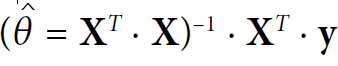

In [22]:
import numpy as np
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing() # get dataset
m, n = housing.data.shape # rows, columns
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data] # add column bias (all 1s)

# tensor flow
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X) # node
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)
with tf.Session() as sess:
    theta_value = theta.eval()
    
print(theta_value)

downloading Cal. housing from http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.tgz to C:\Users\carrai1\scikit_learn_data
[[ -3.74651413e+01]
 [  4.35734153e-01]
 [  9.33829229e-03]
 [ -1.06622010e-01]
 [  6.44106984e-01]
 [ -4.25131839e-06]
 [ -3.77322501e-03]
 [ -4.26648885e-01]
 [ -4.40514028e-01]]


The main benefit of this code versus computing the Normal Equation directly using
NumPy is that TensorFlow will automatically run this on your GPU card if you have
one (provided you installed TensorFlow with GPU support).

Now we can do the same using batch gradient decent (data has been normalized).

The random_uniform() function creates a node in the graph that will generate a
tensor containing random values, given its shape and value range, much like
NumPy’s rand() function.

The assign() function creates a node that will assign a new value to a variable.
In this case, it implements the Batch Gradient Descent step θ(next step) = θ –
η∇θMSE(θ).

The main loop executes the training step over and over again (n_epochs times),
and every 100 iterations it prints out the current Mean Squared Error (mse). You
should see the MSE go down at every iteration.

In [30]:
from sklearn.preprocessing import StandardScaler

n_epochs = 1000
learning_rate = 0.01


scale = StandardScaler()
scaled_housing_data_plus_bias = scale.fit_transform(housing_data_plus_bias)

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
    sess.run(training_op)
    best_theta = theta.eval()
    
print(best_theta)

Epoch 0 MSE = 7.13173
Epoch 100 MSE = 7.13173
Epoch 200 MSE = 7.13173
Epoch 300 MSE = 7.13173
Epoch 400 MSE = 7.13173
Epoch 500 MSE = 7.13173
Epoch 600 MSE = 7.13173
Epoch 700 MSE = 7.13173
Epoch 800 MSE = 7.13173
Epoch 900 MSE = 7.13173
[[-0.92769265]
 [-0.33844805]
 [ 0.0919735 ]
 [ 0.64967823]
 [-0.30598873]
 [-0.67914838]
 [ 0.03372381]
 [ 0.80328095]
 [ 0.68095076]]


if you had to do this with deep neural networks you would get quite a headache:
it would be tedious and error-prone. You could use symbolic differentiation to automatically
find the equations for the partial derivatives for you, but the resulting code
would not necessarily be very efficient.

Fortunately, TensorFlow’s autodiff feature comes to the rescue: it can automatically
and efficiently compute the gradients for you. Simply replace the gradients = ...
line in the Gradient Descent code in the previous section with the following line, and
the code will continue to work just fine:
gradients = tf.gradients(mse, [theta])[0]
The gradients() function takes an op (in this case mse) and a list of variables (in this
case just theta), and it creates a list of ops (one per variable) to compute the gradients
of the op with regards to each variable. So the gradients node will compute the
gradient vector of the MSE with regards to theta.

There are four main approaches to computing gradients automatically. They are summarized
in Table 9-2. TensorFlow uses reverse-mode autodiff, which is perfect (efficient
and accurate) when there are many inputs and few outputs, as is often the case
in neural networks. It computes all the partial derivatives of the outputs with regards
to all the inputs in just noutputs + 1 graph traversals.

So TensorFlow computes the gradients for you. But it gets even easier: it also provides
a number of optimizers out of the box, including a Gradient Descent optimizer. You
can simply replace the preceding gradients = ... and training_op = ... lines
with the following code, and once again everything will just work fine:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)
If you want to use a different type of optimizer, you just need to change one line. For
example, you can use a momentum optimizer (which often converges much faster
than Gradient Descent; see Chapter 11) by defining the optimizer like this:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
momentum=0.9)

So TensorFlow computes the gradients for you. But it gets even easier: it also provides
a number of optimizers out of the box, including a Gradient Descent optimizer. You
can simply replace the preceding gradients = ... and training_op = ... lines
with the following code, and once again everything will just work fine:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)
If you want to use a different type of optimizer, you just need to change one line. For
example, you can use a momentum optimizer (which often converges much faster
than Gradient Descent; see Chapter 11) by defining the optimizer like this:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
momentum=0.9)

placeholder nodes. These nodes are special because
they don’t actually perform any computation, they just output the data you tell them
to output at runtime. They are typically used to pass the training data to TensorFlow
during training. If you don’t specify a value at runtime for a placeholder, you get an
exception.

In [31]:
A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})

print(B_val_1)
print(B_val_2)

[[ 6.  7.  8.]]
[[  9.  10.  11.]
 [ 12.  13.  14.]]


To implement Mini-batch Gradient Descent, we only need to tweak the existing code
slightly. First change the definition of X and y in the construction phase to make them
placeholder nodes:
    
Then define the batch size and compute the total number of batches:
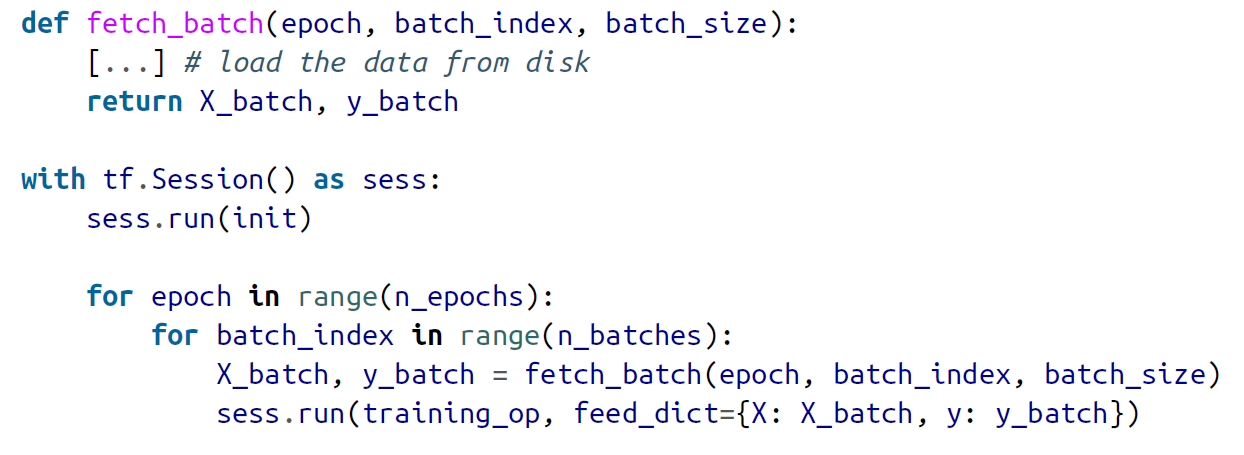

.................

When dealing with more complex models such as neural networks, the graph can
easily become cluttered with thousands of nodes. To avoid this, you can create name
scopes to group related nodes. For example, let’s modify the previous code to define
the error and mse ops within a name scope called "loss:

In [34]:
with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")
    
print(error.op.name)
print(mse.op.name)

loss_1/sub
loss_1/mse


TensorFlow makes saving and restoring a model very easy. Just create a Saver node at
the end of the construction phase (after all variable nodes are created); then, in the
execution phase, just call its save() method whenever you want to save the model,
passing it the session and path of the checkpoint file:

Restoring a model is just as easy: you create a Saver at the end of the construction
phase just like before, but then at the beginning of the execution phase, instead of initializing
the variables using the init node, you call the restore() method of the
Saver object:

By default a Saver saves and restores all variables under their own name, but if you
need more control, you can specify which variables to save or restore, and what
names to use. For example, the following Saver will save or restore only the theta
variable under the name weights:


In [ ]:
# save
#...
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name="theta")
[...]
init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        if epoch % 100 == 0: # checkpoint every 100 epochs
            save_path = saver.save(sess, "/tmp/my_model.ckpt")
        sess.run(training_op)
    best_theta = theta.eval()
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")

# restore
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")

#more controlo to save
saver = tf.train.Saver({"weights": theta})

TensorBoard. If
you feed it some training stats, it will display nice interactive visualizations of these
stats in your web browser (e.g., learning curves). You can also provide it the graph’s
definition and it will give you a great interface to browse through it. This is very useful
to identify errors in the graph, to find bottlenecks, and so on.
The first step is to tweak your program a bit so it writes the graph definition and
some training stats—for example, the training error (MSE)—to a log directory that
TensorBoard will read from. You need to use a different log directory every time you
run your program, or else TensorBoard will merge stats from different runs, which
will mess up the visualizations. The simplest solution for this is to include a timestamp
in the log directory name. 